# Simple OpAmp Voltage Adaption

We try to choose a reference design for the needs of different voltage adaption using different OpAmp transfer characteristics. Therefore we need the expected output voltages for the given input voltages. With this information we can derive the linear transfer function. Depending on sign of the slope and the intercept we choose the corresponding reference design. 

Most of the equations are taken from _OP AMPS FOR EVERYONE ISBN-13: 9780128116487_ from Carter and Mancini as well as the document _Designing Gain and Offset in Thirty Seconds_ from Ti ([SLOA097](https://www.ti.com/lit/an/sloa097/sloa097.pdf?ts=1669554471541&ref_url=https%253A%252F%252Fwww.google.com%252F))

To derive the transfer function you have to provide two pairs of input and output values.

* x1 is the first input value e.g. the minimum value for the input
* y1 is the expected output vale for x1
* x2 is the second input vale e.g. the maximum value for the input
* y2 ist the expected output value for x2

After specifying the values the linear transfer function is derived in the form of $y=\pm m*x\pm b$

Depending on the sign of slope $m$ and intercept $b$ different OpAmp configurations will be used to fulfill the transfer function.
We do not take into account the frequency or stability of the chosen reference design for now.
 

## Define transfer characteristic

Define input (x-values) and output (y-values) voltages for the extremes on the input and the expected output voltages. No need to have it ordered (low to FS or vice versa)


In [28]:
from sympy import  Rational,S
#### Signal levels
#Output:
#Tri: 0V to Vcc*1/3
#Saw: 0V to 2/3*Vcc
#Pulse: 0V to Vcc-0.9V
#Input:
#PWM 0V to 1/3*Vcc (0%-100%)

#Vcc of Device
Vcc=10

#Voltage to generate Offset from
Vx=12

#x1 is the first extreme input voltage
#y1 corresponds to the input of x1

#PWM Input +-5 to Vcc/3, inverted
x1=Rational(47/10); y1=0; x2=-Rational(47/10); y2=Rational(Vcc,3)

#Tri output, limit to 4.8V, 9.6Vpp
#x1=0; y1=-Rational(48,10); x2=Rational(Vcc,3); y2=Rational(48,10)


#SAW output case2 (max. 7.4 Vpp, 7.0 max +)
#x1=0; y1=-5; x2=Rational(2*Vcc,3); y2=5


#Pulse inverted output case3
#x1=Rational((Vcc-0.8)); y1=-5; x2=-.15; y2=5

#Comparator Output +-12 to +-5V
x1=5; y1=3.3; x2=-5; y2=0


In [29]:
%matplotlib inline
#%pip install sympy numpy pyspice

In [30]:
import sympy as sp
from sympy import solve, symbols, nsimplify, Rational, latex, Eq, solveset, S, linsolve, Matrix, N
from IPython.display import Math, display

# Importing packages
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter
from IPython.display import Markdown as md


sp.init_printing()


## Develop the transfer function

Usually we have a linear transfer function expressed in the form 

$$ 
y =\pm \,mx\pm \,b
$$

Now calculate the $slope$ $m$ and $intercept$ $b$ with 

* $x_{1}$ for the first input Voltage to get $y_{1}$ output voltage
* $x_{2}$ for the second input voltage to get $y_{2}$ output voltage

For all two pairs of $x_{..}$ and $y_{..}$ values we define a linear function to determine $slope=m$ and $intercept=b$


[Reference](https://www.ti.com/lit/an/sloa097/sloa097.pdf)


#### Slope & Intercept

Resolve slope & intercept. Two unknowns with two functions.

In [31]:

y,x,m, b=symbols('y x m b', real=True)
lin_eq=Eq(y,m*x+b)
m,b=itemgetter(m,b)(solve([
lin_eq.subs([(x,x1),(y,y1)]),
lin_eq.subs([(x,x2),(y,y2)])
],
[m,b],
))
{'m':m,'b':b}

{'m': 0.330000000000000, 'b': 1.65000000000000}

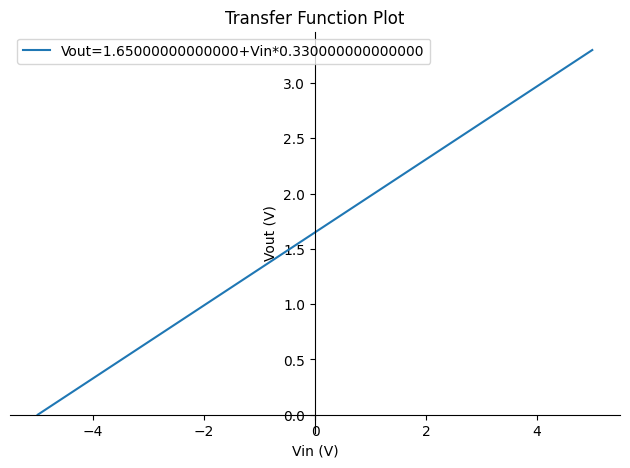

In [32]:
sp.plot(m*x+b, (x,x1,x2),label=f"Vout={b}+Vin*{m}", xlabel="Vin (V)", ylabel="Vout (V)", title="Transfer Function Plot", legend=True, adaptive=True, nb_of_points=10)

## Identify Case
Now we know the transfer function we can derive the case (which OpAmp Circuit) we can use to fulfill the requirements.

In [33]:
invertingOpAmp="Inverting OpAmp"
nonInvertingOpAmp="Non Inverting OpAmp"
isInvertingOpAmp, opAmpType= (True,invertingOpAmp) if float(m) < 0 else (False,nonInvertingOpAmp)

isPostitiveIntercept,interceptSign=(True,"positive") if float(b) > 0 else (False,"negative")

nisa="Non-Inverting Summing Amplifier, b is positive so applied to V+, Non Inverting Adder, proceed with Case 1"
nino="Non-Inverting with Negative Offset, b is negative so applied to V-, proceed with Case 2"
iapo="Inverting Amplifier, b is positive so applied to V+, Differential Amplifier, proceed with Case 3"
iano="Differential Amplifier, b is negative so applied to V-, Adder, proceed with Case 4"
nivpoff= "Non-Inverting Attenuation with Positive Offset, passively mixed"

referenceCircuit="Unknown"
case=0

if (not isInvertingOpAmp and isPostitiveIntercept):
        referenceCircuit=nisa
        case=1
if (not isInvertingOpAmp and not isPostitiveIntercept):
        referenceCircuit=nino
        case=2
if (isInvertingOpAmp and isPostitiveIntercept):
        referenceCircuit=iapo
        case=3
if (isInvertingOpAmp and not isPostitiveIntercept):
        referenceCircuit=iano
        case=4
if (not isInvertingOpAmp and isPostitiveIntercept and m <= 1):
        referenceCircuit=nivpoff
        case=7

f"y={m}*x+{b} We have a {opAmpType} with a {interceptSign} offset. {referenceCircuit}"


'y=0.330000000000000*x+1.65000000000000 We have a Non Inverting OpAmp with a positive offset. Non-Inverting Attenuation with Positive Offset, passively mixed'

In [34]:
md(f"## Proceed to [Case{case}](./02-case{case}.ipynb)")

## Proceed to [Case7](./02-case7.ipynb)

In [35]:
# Keep this vales as we need them in the Notebooks for the different cases
%store m
%store b
%store x1
%store y1
%store x2
%store y2
%store case
%store Vx
%store Vcc

Stored 'm' (Float)
Stored 'b' (Float)
Stored 'x1' (int)
Stored 'y1' (float)
Stored 'x2' (int)
Stored 'y2' (int)
Stored 'case' (int)
Stored 'Vx' (int)
Stored 'Vcc' (int)
